In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# Plotting the NCMC acceptance rate for HIP in explicit solvent

Seeing how the number of NCMC perturbations affects the acceptance rate of HIP (the AMBER name for fully protonated histidine) for constant-pH simulations with `protons`.

The list below shows the number of NCMC perturbation steps that were used. Each perturbation step is followed by 1fs of dynamics. For example, 10000 perturbation steps means that the simulation time for NCMC protocol is 10ps.

In [2]:
nperts = [0, 100, 1000, 5000, 10000, 20000, 30000]

Loading the data from the simulations and plotting the acceptance rate. The data reported is from 500 iterations of molecular dynamics and `protons` steps. A single iteration consisted of 500 steps of MD (with a 2fs timestep) and 1 proton insertion deletion attempt using NCMC.

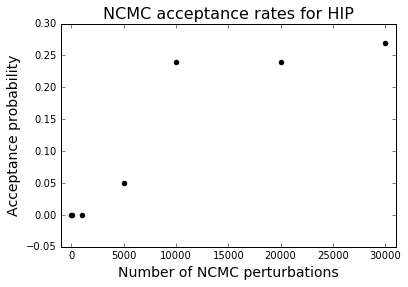

In [3]:
# Reading the simulation data
accprob = []      # where the acceptance will be stored
for p in nperts:
    filename = str(p) + '_ncmc_steps/out.txt'
    lines = open(filename,'r').readlines()
    accprob.append(float(lines[-1].split()[2]))
    
# Plotting
plt.scatter(nperts, accprob, color='k')
plt.title('NCMC acceptance rates for HIP', fontsize=16)
plt.xlabel('Number of NCMC perturbations', fontsize=14)
plt.ylabel('Acceptance probability', fontsize=14)
plt.xlim((-1000,nperts[-1]+1000))
plt.show()

For '0 NCMC steps', instantaneous swas